# UCAI - Digital Me

## 0. Module import & Google drive mount

In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds

import tqdm
import os
import random
import re

import matplotlib.pyplot as plt
import time
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. Data Preprocessing

### 문제별 tag 분포 확인

Text(0, 0.5, 'prop of questions')

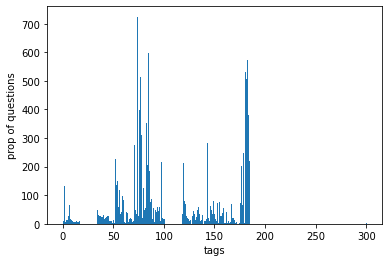

In [ ]:
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions.csv", usecols = ['question_id','tags'])
question_tags, all_tag, prop_tag = [], [], []

# tag의 종류에 따른 비율 계산해서 리스트로 만들기
for i in range(len(question_info)):
    question_tags = question_info.loc[i].tags.split(';')
    
    for i in range(len(question_tags)):
        all_tag.append(int(question_tags[i]))
        prop_tag.append(1/len(question_tags))       

# 문제마다 tag 분포를 개수로 확인 (ex. q1 - 1(1), 2(1), 179(1), 181(1))
# tag의 분포를 확인하기 위한 dictionary 생성
tag_distribution = {}

for i in range(300+1):
    tag_distribution[str(i)] = 0

for j in range(300+1):
    tag_distribution[str(j)] = all_tag.count(j)
          
# dictionary를 이용해 데이터 프레임 생성            
tag_data = pd.DataFrame(tag_distribution, index = ['number'])
# tag_data.to_csv("D:/EdNet/question_tags.csv", index = False)

plt.bar(range(300+1), tag_data.loc['number'])
plt.xlabel("tags")
plt.ylabel("questions")
# plt.savefig('D:/EdNet/question_tags.jpg')

# 문제마다 tag 분포를 비율로 확인 (ex. q1 - 1(1/4), 2(1/4), 179(1/4), 181(1/4))
# tag의 분포를 확인하기 위한 dictionary 생성
tag_distribution_prop = {}

for i in range(300+1):
    tag_distribution_prop[str(i)] = 0

for i in range(len(all_tag)):
    for j in range(300+1):
        if all_tag[i] == j:
            tag_distribution_prop[str(j)] += prop_tag[i]
            
# dictionary를 이용해 데이터 프레임 생성            
tag_data_prop = pd.DataFrame(tag_distribution_prop, index = ['number'])
# tag_data_prop.to_csv("D:/EdNet/question_tags_prop.csv", index = False)

plt.bar(range(300+1), tag_data_prop.loc['number'])
plt.xlabel("tags")
plt.ylabel("prop of questions")

# plt.savefig('D:/EdNet/question_tags_prop.jpg')

### KT1 데이터 중 랜덤으로 1% 선택해서 이용

In [ ]:
start = time.time()

# 파일 리스트 및 데이터 저장할 폴더 경로 지정
file_dir = "/content/gdrive/My Drive/Colab Notebooks/EdNet/KT1"
data_dir = "/content/gdrive/My Drive/Colab Notebooks/EdNet/data_preprocess"

# 데이터의 1%를 random으로 선택
file_list = os.listdir(file_dir)
file_list = random.sample(os.listdir(file_dir), len(file_list)//100)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# question_id, correct_answer, tags 값만 사용
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions.csv", usecols = ['question_id','correct_answer','part','tags'])
tag_data_re = tag_data_prop.transpose()

# tag의 문제당 비율이 20 미만인 경우
delete_tag = [] 
for i in range(len(tag_data_re)):
    if tag_data_re.iloc[i].number < 20:
        delete_tag.append(i)

# 해당 tag가 포함된 문제는 모두 제거
delete_index = []
for i in range(len(question_info)):
    question_tags = question_info.loc[i].tags.split(';')
    for j in range(len(question_tags)):
        if int(question_tags[j]) in delete_tag:
            delete_index.append(i)
            break

question_info_del = question_info.drop(index = delete_index)
question_info_del = question_info_del.reset_index(drop = True)

# EdNet KT1 데이터 이용
for file_name in file_list:
    user_list = os.path.join(file_dir + "/" + file_name)
    user_info = pd.read_csv(user_list)
    
    # 문제에 답을 하지 않았을 경우에는 행 제거
    user_info = user_info.dropna(axis = 0)
    user_info = user_info.reset_index(drop = True)
   
    # row마다 question에 맞는 correct_answer, tags 데이터 추가
    question_info_re = question_info.set_index('question_id')
    question_data = question_info_re.loc[user_info.loc[0:len(user_info)].question_id]
    user_data = pd.concat([user_info, question_data.reset_index(drop = True)], axis = 1)
    
    # user 이름 추가해서 데이터 재배열
    user_data['user'] = [file_name.replace('.csv', '') for i in range(len(user_data))]
    user_data = user_data[['user', 'timestamp',  'question_id', 'part', 'tags', 'correct_answer', 'user_answer', 'elapsed_time']]
    
    # question_info_del에 없는 문제에 대한 데이터 제거
    delete_index_user = []
    for i in range(len(user_info)):
        if user_data.loc[i].question_id not in list(question_info_del.question_id):
            delete_index_user.append(i)
            
    user_data = user_data.drop(index = delete_index_user)
    user_data.to_csv(os.path.join(data_dir + "/" + file_name), index = False)


# 해당 폴더 안에 모든 파일 리스트 불러오기
all_filelist = os.listdir(data_dir)
all_data = pd.DataFrame()

# 폴더 안에 있는 엑셀 파일 모두 합치기
for file_name in all_filelist:
    df = pd.read_csv(data_dir + '/' + file_name)
    all_data = all_data.append(df, ignore_index = True)

all_data.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/input_data.csv", index = False)

end = time.time()
print(datetime.timedelta(seconds = end - start))

In [ ]:
# user_data를 21개 단위로 나눴을 때 남는 데이터(21개보다 적은 경우)는 제거
data_dir_1 = "/content/gdrive/My Drive/Colab Notebooks/EdNet/data_preprocess_1"
data_list = os.listdir(data_dir)

if not os.path.exists(data_dir_1):
    os.makedirs(data_dir_1)
    
for file_name in data_list:
    user_list_1 = os.path.join(data_dir + "/" + file_name)
    user_data_1 = pd.read_csv(user_list_1)

    user_data_1 = user_data_1.iloc[0:len(user_data_1) - len(user_data_1)%21]
    
    # 아무것도 데이터가 남지 않는 경우는 저장 X
    if len(user_data_1) != 0:
        user_data_1.to_csv(os.path.join(data_dir_1 + "/" + file_name), index = False)

        
# 해당 폴더 안에 모든 파일 리스트 불러오기
all_filelist_1 = os.listdir(data_dir_1)
all_data_1 = pd.DataFrame()

# 21개 묶음 개수 세기
count = []

# 폴더 안에 있는 엑셀 파일 모두 합치기
for file_name in all_filelist_1:
    df_1 = pd.read_csv(data_dir_1 + '/' + file_name)
    all_data_1 = all_data_1.append(df_1, ignore_index = True)
    
    count.append(len(df_1)//21)

all_data_1.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/input_data_1.csv", index = False)

## 2. State Prediction
참고 출처 : https://wikidocs.net/31379, https://wikidocs.net/89786

### 데이터 나누기 (21개, Train 20 + Label 1)

In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/input_data.csv")

# 정오답 여부 추가
correctness = []
for i in range(len(data)):
  if data.loc[i].user_answer == data.loc[i].correct_answer:
    correctness.append('O')
  else:
    correctness.append('X')

data['correctness'] = correctness

# 데이터를 21개 단위로 분할
input_list = []

start = 0
while (start <= len(data)):
    end = start + 20
    input_list.append(data.loc[start:end])
    
    start = end + 1

# input_list의 마지막 값의 길이가 21보다 작으면 제거
if len(input_list[-1]) < 21:
    input_list.pop()

# 20(train) + 1(label)로 데이터 추가 분할
train_list, label_list = [], []
for i in range(len(input_list)):
    train_list.append(input_list[i].iloc[0:-1])
    label_list.append(input_list[i].iloc[-1])

# train, label 리스트를 데이터 프레임으로 변환
train_df = pd.concat([train_list[i] for i in range(len(train_list))])
train_df = train_df.reset_index(drop = True)

label_df = pd.concat([label_list[i] for i in range(len(label_list))], axis = 1).transpose()
label_df = label_df.reset_index(drop = True)

# train, label 데이터프레임 csv 파일로 저장
train_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/train_data_list.csv", index = False)
label_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/label_data_list.csv", index = False)

In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/input_data.csv")
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/train_data_list.csv")
label_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/label_data_list.csv")

# 사용자, 문제번호마다 걸린 시간이 너무 다르기 때문에 예측 결과가 정확도가 매우 낮을 것으로 예상
# 각각의 구간의 평균을 기준으로 정해서 4개의 구간으로 나눠서 확인.

# 전체 data => 평균값 a 를 기준으로 구간 1, 2로 분할
# 구간 1 => 평균값 b를 기준으로 구간 1_1, 1_2로 분할
# 구간 2 => 평균값 c를 기준으로 구간 2_1, 2_2로 분할

# 최종적으로 전체 data에 대해서 구간 1_1(A), 구간 1_2(B), 구간 2_1(C), 구간 2_2(D) 존재
# 오른쪽으로 갈수록 시간이 오래 걸린 구간 (A < B < C < D)

time_list = [data.loc[i].elapsed_time for i in range(len(data))]
time_mean = sum(time_list) / len(time_list)

time_1, time_2 = [], []

for i in range(len(data)):
  if(data.loc[i].elapsed_time < time_mean):
    time_1.append(data.loc[i].elapsed_time)
  else:
    time_2.append(data.loc[i].elapsed_time)

time_1_1, time_1_2, time_2_1, time_2_2 = [], [], [], []

time_mean_1 = sum(time_1) / len(time_1)
time_mean_2 = sum(time_2) / len(time_2)

for i in range(len(time_1)):
  if(time_1[i] < time_mean_1):
    time_1_1.append(time_1[i])
  else:
    time_1_2.append(time_1[i])
  
for i in range(len(time_2)):
  if(time_2[i] < time_mean_2):
    time_2_1.append(time_2[i])
  else:
    time_2_2.append(time_2[i])

# Train data에 대해서 각 행마다 elapsed_time에 맞게 속해있는 구간 확인
time_type_t = []
for i in range(len(train_df)):
  if train_df.loc[i].elapsed_time in time_1_1:
    time_type_t.append('A')

  elif train_df.loc[i].elapsed_time in time_1_2:
    time_type_t.append('B')

  elif train_df.loc[i].elapsed_time in time_2_1:
    time_type_t.append('C')

  elif train_df.loc[i].elapsed_time in time_2_2:
    time_type_t.append('D')

# Label data에 대해서 각 행마다 elapsed_time에 맞게 속해있는 구간 확인
time_type_l = []
for i in range(len(label_df)):
  if label_df.loc[i].elapsed_time in time_1_1:
    time_type_l.append('A')

  elif label_df.loc[i].elapsed_time in time_1_2:
    time_type_l.append('B')

  elif label_df.loc[i].elapsed_time in time_2_1:
    time_type_l.append('C')

  elif label_df.loc[i].elapsed_time in time_2_2:
    time_type_l.append('D')

train_df['time_type'] = time_type_t
train_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/train_data_list.csv", index = False)

label_df['time_type'] = time_type_l
label_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/label_data_list.csv", index = False)

### Train data 리스트 생성


In [ ]:
train_df_1 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/train_data_list.csv")
label_df_1 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/label_data_list.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions.csv", usecols = ['question_id','correct_answer'])

question = {}
for i in range(len(question_info)):
  question[question_info.loc[i].question_id] = question_info.loc[i].correct_answer

# train_df_1에서 정오답 여부 확인
correct_answer_t, correctness_t = [], []
for i in range(len(train_df_1)):
  correct_answer_t.append(question[train_df_1.loc[i].question_id])

  if train_df_1.loc[i].user_answer == question[train_df_1.loc[i].question_id]:
    correctness_t.append('O')
  else:
    correctness_t.append('X')

train_df_1['correct_answer'] = correct_answer_t
train_df_1['correctness'] = correctness_t

# label_df_1에서 정오답 여부 확인
correct_answer_l, correctness_l = [], []
for i in range(len(label_df_1)):
  correct_answer_l.append(question[label_df_1.loc[i].question_id])

  if label_df_1.loc[i].user_answer == question[label_df_1.loc[i].question_id]:
    correctness_l.append('O')
  else:
    correctness_l.append('X')

label_df_1['correct_answer'] = correct_answer_l
label_df_1['correctness'] = correctness_l

# train data의 User + 문제번호, 정오답 + 시간 type을 나눠서 각각 리스트에 append
user_question_t, answer_time_t = [], []

for i in range(len(train_df_1)):
    user_question_t.append(train_df_1.loc[i].user + " " + train_df_1.loc[i].question_id)
    answer_time_t.append(train_df_1.loc[i].correctness)
    # answer_time_t.append(train_df_1.loc[i].correctness + " " + train_df_1.loc[i].time_type)

# label data의 User + 문제번호, 정오답 + 시간 type을 나눠서 각각 리스트에 append
user_question_l, answer_time_l = [], []
    
for i in range(len(label_df_1)):
    user_question_l.append(label_df_1.loc[i].user + " " + label_df_1.loc[i].question_id)
    answer_time_l.append(label_df_1.loc[i].correctness)
    # answer_time_l.append(label_df_1.loc[i].correctness + " " + label_df_1.loc[i].time_type)

In [ ]:
# Train data가 Transformer에 Input으로 들어갈 수 있도록 토큰화 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(user_question_t + answer_time_t, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2 #원래 vocab_size에 시작토큰, 종료토큰 더해서 2플러스해줌
MAX_LENGTH = 128

# input, Output은 아래 예시처럼 경우에 맞게 설정
# Ex. 챗봇 -> Input = 질문 ("지금 몇 시야?"), Output = 대답 ("8시입니다.")
# Ex. Riiid -> Input = 사용자 + 문제 번호, Output = 정오답 여부
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

user_question_t, answer_time_t = tokenize_and_filter(user_question_t, answer_time_t)

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': user_question_t,
        'dec_inputs': answer_time_t[:, :-1] # 디코더의 입력. 마지막 패딩 토큰 제거
    },
    {
        'outputs': answer_time_t[:, 1:]  # 맨 처음 토큰 제거
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Transformer 모델 (Tensorflow 이용)



#### Model Architecture

In [ ]:
### scaled_dot_product_attention
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # padding을 위해 mask 추가
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention 클래스
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # head 합치기
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

### masking 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### look_ahead_mask(디코더때 쓰임)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding 클래스
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 짝수에 sin 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 홀수에 cos 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### encoder
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
          })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
# Encoder 함수
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
          })
    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
          })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)
  
# Decoder 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)
  
# Transforemr 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='enc_padding_mask')(inputs)
    look_ahead_mask = tf.keras.layers.Lambda(
          create_look_ahead_mask,
          output_shape=(1, None, None),
          name='look_ahead_mask')(dec_inputs)
    dec_padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
# 학습을 위해 loss function 정의
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# 학습을 위한 클래스
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
tf.keras.backend.clear_session() #초기화 할때 사용 런타임 다시 정하기 귀찮을때 싹 지워버림

# Hyperparameters

# Layer 수 조정
NUM_LAYERS = 2

# 기타 hyperparameters
D_MODEL = 128
NUM_HEADS = 4
UNITS = 256
DROPOUT = 0.2


model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)

In [ ]:
# Learning rate 설정
learning_rate = CustomSchedule(D_MODEL)

# Optimizer = Adam
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 학습을 위해 transformer를 위한 accuracy 정의
def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 10 # 학습 Epochs

In [ ]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

Wed Dec  8 05:33:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |    437MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 모델 학습

In [ ]:
model.summary()

# 모델의 가중치 저장
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/EdNet/model/checkpoint.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                                 save_weights_only = True, 
                                                 verbose = 1)

model.fit(dataset, epochs = EPOCHS, callbacks = [cp_callback]) # 학습

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 128)    1308544     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

#### 정오답 예측

In [ ]:
# 검증 관련 함수
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()

  return sentence

def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

#   print('Input: {}'.format(sentence))
#   print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
# Transformer 모델 load
model.load_weights("/content/gdrive/My Drive/Colab Notebooks/EdNet/model/checkpoint.ckpt")

# 예측 과정 / 시간 소모가 가장 큼
tqdm.tqdm.pandas()
label_predict = pd.DataFrame()

label_predict['user_question'] = user_question_l
predict_token = label_predict['user_question'].progress_apply(predict)

label_predict['label'] = answer_time_l
label_predict['predict'] = predict_token
label_predict.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/predict_correctness.csv", index = False)

label_predict

In [ ]:
predict_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/predict_correctness.csv")
label_time, predict_time = [], []

# 기존 데이터와 예측 결과에 대해서 정답, 걸린 시간 일치 여부 확인 
for i in range(len(predict_df)):
  if predict_df.loc[i].label[2:] == 'A':
    label_time.append('shortest')
  elif predict_df.loc[i].label[2:] == 'B':
    label_time.append('middle1')
  elif predict_df.loc[i].label[2:] == 'C':
    label_time.append('middle2')
  else:
    label_time.append('longest')

for i in range(len(predict_df)):
  if predict_df.loc[i].predict[2:] == 'A':
    predict_time.append('shortest')
  elif predict_df.loc[i].predict[2:] == 'B':
    predict_time.append('middle1')
  elif predict_df.loc[i].predict[2:] == 'C':
    predict_time.append('middle2')
  else:
    predict_time.append('longest')


label, predict = [], []
for i in range(len(predict_df)):
  label.append(predict_df.loc[i].label[0:1] + " " + label_time[i])
  predict.append(predict_df.loc[i].predict[0:1] + " " + predict_time[i])

predict_df['label'] = label
predict_df['predict'] = predict

count = []
for i in range(len(predict_df)):
  if (predict_df.loc[i].label == predict_df.loc[i].predict):
    count.append(1)
  else:
    count.append(0)

print("일치 : ", count.count(1), "\t", "불일치 : ", count.count(0))

### Collaborative Filtering

In [ ]:
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/train_data_list.csv")

# train_df에 대해서 사용자를 key 값으로 갖는 dictionary 생성
user_list_t = list(set(train_df['user']))
user_info_t = {}
for i in range(len(user_list_t)):
  user_info_t[user_list_t[i]] = []

# (문제번호, 정오답 여부) 순서쌍을 해당 dictionary의 value로 설정
for i in range(len(train_df)):
  user_info_t[train_df.loc[i].user].append((train_df.loc[i].question_id, train_df.loc[i].correctness))

# 유사도 matrix 계산
# 두 사용자가 같은 문제를 풀었을 때 정오답 여부가 같으면 +1, 아닌 경우 +0
user_sim_matrix = np.zeros([len(user_list_t), len(user_list_t)])
for i in range(len(user_list_t)):
  for j in range(len(user_list_t)):
    user_sim_matrix[i][j] = len(set(user_info_t[user_list_t[i]]) & set(user_info_t[user_list_t[j]]))

np.save("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_sim_matrix", user_sim_matrix)

In [ ]:
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/train_data_list.csv")

# train_df에 대해서 사용자를 key 값으로 갖는 dictionary 생성
user_list_t = list(set(train_df['user']))

# numpy array를 pandas dataframe으로 변환
user_sim_matrix = np.load("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_sim_matrix.npy")

user_sim_df = pd.DataFrame(user_sim_matrix)
user_sim_df.columns = [user_list_t[i] for i in range(len(user_list_t))]
user_sim_df.index = [user_list_t[i] for i in range(len(user_list_t))]

In [ ]:
user_sim_df

,u794373,u412981,u637353,u615395,u306215,u828727,u324132,u25511,u151414,u37820,u48770,u517069,u550790,u286191,u140155,u360776,u53760,u647312,u820378,u24414,u552002,u379191,u366703,u521913,u512841,u719082,u19434,u653039,u310429,u173177,u538614,u367350,u139450,u286382,u674572,u808368,u79158,u374987,u819954,u37519,...,u351213,u706750,u716254,u233391,u117948,u32104,u109236,u345572,u166637,u173183,u668775,u54735,u153403,u36892,u429873,u610849,u406991,u570861,u205439,u208712,u819449,u218733,u225959,u216472,u563784,u330901,u736795,u625087,u715449,u647930,u305682,u265855,u197028,u56961,u44725,u649070,u567614,u668862,u349986,u348683
u794373,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
u412981,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
u637353,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
u615395,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
u306215,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u649070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24.0,3.0,0.0,1.0,0.0
u567614,2.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,3.0,0.0,9.0,1.0,1.0,0.0,0.0,45.0,1.0,1.0,0.0,14.0,1.0,14.0,1.0,10.0,13.0,1.0,5.0,15.0,16.0,73.0,2.0,...,0.0,18.0,0.0,0.0,0.0,4.0,19.0,23.0,2.0,0.0,14.0,0.0,3.0,1.0,20.0,2.0,6.0,17.0,18.0,20.0,4.0,17.0,0.0,217.0,1.0,0.0,0.0,4.0,0.0,5.0,3.0,12.0,2.0,94.0,1.0,3.0,1768.0,1.0,285.0,1.0
u668862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0
u349986,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,3.0,0.0,7.0,0.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,0.0,1.0,0.0,14.0,2.0,0.0,0.0,8.0,0.0,13.0,0.0,15.0,3.0,1.0,2.0,8.0,10.0,75.0,0.0,...,6.0,8.0,0.0,0.0,0.0,0.0,9.0,11.0,1.0,0.0,10.0,1.0,0.0,0.0,10.0,2.0,3.0,8.0,8.0,7.0,2.0,8.0,0.0,307.0,0.0,0.0,1.0,2.0,0.0,19.0,0.0,32.0,0.0,146.0,1.0,1.0,285.0,0.0,1504.0,1.0


In [ ]:
label_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/label_data_list.csv")

# label_df에 대해서 사용자를 key 값으로 갖는 dictionary 생성
user_list_l = list(set(label_df['user']))
user_info_l = {}
for i in range(len(user_list_l)):
  user_info_l[user_list_l[i]] = []

# (문제번호, 정오답 여부) 순서쌍을 해당 dictionary의 value로 설정
for i in range(len(label_df)):
  user_info_l[label_df.loc[i].user].append((label_df.loc[i].question_id, label_df.loc[i].correctness))

## 3. Recommendation System

### User-Question Matrix + 오답 비율 계산

In [ ]:
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/input_data.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process.csv")

# Tag 값이 -1인 question 제거
delete_question = []
for i in range(len(question_info)):
  if '-1' in question_info.loc[i].tags.split(';'):
    delete_question.append(i)

question_info = question_info.drop(index = delete_question)
question_info = question_info.reset_index(drop = True)
question_info.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv", index = False)

# 사용자 번호, 문제 번호 리스트 생성
question_list = list(question_info['question_id'])
user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)

# user_info에 대해서 사용자를 key 값으로 갖는 dictionary 생성
user_dict = {}
for i in range(len(user_list)):
  user_dict[user_list[i]] = []

# (문제번호, 정오답 여부) 순서쌍을 해당 dictionary의 value로 설정
for i in range(len(user_info)):
  user_dict[user_info.loc[i].user].append((user_info.loc[i].question_id, user_info.loc[i].correctness))

# 문제풀이 데이터가 20개 미만인 사용자의 경우 제외
delete_user = []
for i in range(len(user_info)):
  if len(user_dict[user_info.loc[i].user]) < 20:
    delete_user.append(i)

user_info = user_info.drop(index = delete_user)
user_info = user_info.reset_index(drop = True)
user_info.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv", index = False)

# 사용자 번호 리스트 업데이트
user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)

# 모든 사용자의 처음 20개 문제풀이 데이터 선택
user_data = pd.DataFrame()
for i in range(len(user_list)):
  user_data_add = user_info[user_info['user'] == user_list[i]].head(20)   # 20개 선택
  user_data = pd.concat([user_data, user_data_add], ignore_index = True)

user_data.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_data.csv", index = False)

# user_data_20에 대해서 사용자를 key 값으로 갖는 dictionary 생성
user_dict_20 = {}
for i in range(len(user_list)):
  user_dict_20[user_list[i]] = []

# (문제번호, 정오답 여부) 순서쌍을 해당 dictionary의 value로 설정
for i in range(len(user_data)):
  user_dict_20[user_data.loc[i].user].append((user_data.loc[i].question_id, user_data.loc[i].correctness))

# User-Question matrix 생성
user_question_matrix = np.empty((len(user_list), len(question_list)), object)
for i in range(len(user_list)):
  for j in range(len(question_list)):
    if (question_list[j], 'O') in user_dict_20[user_list[i]]:
      user_question_matrix[i][j] = 'O'
    elif (question_list[i], 'X') in user_dict_20[user_list[i]]:
      user_question_matrix[i][j] = 'X'
    else:
      user_question_matrix[i][j] = ''

np.save("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_question_matrix", user_question_matrix)

In [ ]:
# User-Question matrix - numpy array를 pandas dataframe으로 변환
user_question_matrix = np.load("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_question_matrix.npy", allow_pickle = True)

user_question_df = pd.DataFrame(user_question_matrix)
user_question_df.index = [user_list[i] for i in range(len(user_list))]
user_question_df.columns = [question_list[i] for i in range(len(question_list))]

# 문제별 오답 비율 계산
ratio_wrong = []

for i in range(len(question_list)):
  c_list = list(user_question_df[question_list[i]])
  c = c_list.count('O')
  w = c_list.count('X')
  if c + w == 0:
    ratio_wrong.append('')
  else:
    ratio_wrong.append(w / (c + w))

user_question_df.loc['wrong_ratio'] = ratio_wrong
user_question_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_question_df.csv", index = False)
user_question_df

,q22,q24,q25,q26,q28,q35,q45,q48,q49,q55,q61,q70,q75,q81,q83,q96,q97,q104,q125,q127,q130,q146,q151,q163,q176,q177,q190,q197,q198,q199,q201,q202,q203,q206,q208,q209,q210,q211,q214,q215,...,q18102,q18103,q18104,q18105,q18106,q18107,q18108,q18109,q18110,q18111,q18112,q18113,q18114,q18115,q18116,q18117,q18118,q18119,q18120,q18121,q18122,q18123,q18124,q18125,q18126,q18127,q18128,q18129,q18130,q18131,q18132,q18133,q18134,q18135,q18137,q18138,q18139,q18140,q18141,q18142
u100003,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u100014,,,,,,,,,,,,,,,,,,,,,,,,,O,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u100039,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u100177,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u100397,,,,,,,,,,,,,,,,,,,,,,,,,O,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u99834,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u99849,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u9985,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u99927,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Transformer 모델 (Tensorflow 이용)



#### Train data 리스트 생성


In [3]:
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
user_data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_data.csv")

user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)

user_random = 'u146540'
# user_random = user_list[random.randrange(0, len(user_list))]

# 모델을 학습시킬 리스트 생성 (사용자 + 문제번호 / 정오답)
train_list_1, train_list_2 = [], []
for i in range(len(user_data)):
  train_list_1.append(user_data.loc[i].user + " " + user_data.loc[i].question_id)
  train_list_2.append(user_data.loc[i].correctness)

# 정오답 여부를 예측할 Input 리스트 생성 (사용자 + 문제번호)
user_question_dict = {}

for i in range(len(user_list)):
  user_question_dict[user_list[i]] = []

for i in range(len(user_data)):
  user = user_data.loc[i].user
  question = user_data.loc[i].question_id
  user_question_dict[user].append(question)

label_list = []
for j in range(len(question_info)):
  question = question_info.loc[j].question_id
  if question not in user_question_dict[user_random]:
    label_list.append(user_random + " " + question)

In [4]:
# Train data가 Transformer에 Input으로 들어갈 수 있도록 토큰화 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_list_1 + train_list_2, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2 #원래 vocab_size에 시작토큰, 종료토큰 더해서 2플러스해줌
MAX_LENGTH = 128

# input, Output은 아래 예시처럼 경우에 맞게 설정
# Ex. 챗봇 -> Input = 질문 ("지금 몇 시야?"), Output = 대답 ("8시입니다.")
# Ex. Riiid -> Input = 문제 번호, Output = 정답 + 걸린 시간
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

train_list_1, train_list_2 = tokenize_and_filter(train_list_1, train_list_2)

In [5]:
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_list_1,
        'dec_inputs': train_list_2[:, :-1] # 디코더의 입력. 마지막 패딩 토큰 제거
    },
    {
        'outputs': train_list_2[:, 1:]  # 맨 처음 토큰 제거
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

#### Model Architecture

In [6]:
### scaled_dot_product_attention
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # padding을 위해 mask 추가
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention 클래스
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # head 합치기
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

### masking 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### look_ahead_mask(디코더때 쓰임)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding 클래스
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 짝수에 sin 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 홀수에 cos 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### encoder
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
          })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
# Encoder 함수
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
          })
    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
          })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)
  
# Decoder 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)
  
# Transforemr 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='enc_padding_mask')(inputs)
    look_ahead_mask = tf.keras.layers.Lambda(
          create_look_ahead_mask,
          output_shape=(1, None, None),
          name='look_ahead_mask')(dec_inputs)
    dec_padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [7]:
tf.keras.backend.clear_session() #초기화 할때 사용 런타임 다시 정하기 귀찮을때 싹 지워버림

# Hyperparameters

# Layer 수 조정
NUM_LAYERS = 2

# 기타 hyperparameters
D_MODEL = 128
NUM_HEADS = 4
UNITS = 256
DROPOUT = 0.2

model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)

In [8]:
# 학습을 위해 loss function 정의
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# 학습을 위한 클래스
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
# 학습을 위해 transformer를 위한 accuracy 정의
def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# Learning rate 설정
learning_rate = CustomSchedule(D_MODEL)

# Optimizer = Adam
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 10 # 학습 Epochs

In [9]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

Thu Feb  3 01:59:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |    441MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 모델 학습

In [10]:
model.summary()
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/EdNet/model/train.ckpt"

# 모델 가중치를 저장하는 callback 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only = True,
                                                 verbose = 1)

model.fit(dataset, epochs = EPOCHS, callbacks = [cp_callback]) # 학습

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 128)    1390464     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

#### 정오답 예측

In [11]:
# 검증 관련 함수
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()

  return sentence

def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

#   print('Input: {}'.format(sentence))
#   print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [12]:
# label_list에 대해서 정오답 여부 예측 
tqdm.tqdm.pandas()
c_predict = pd.DataFrame()
c_predict['user_question'] = label_list

predict = c_predict['user_question'].progress_apply(predict)
c_predict['predict'] = predict
c_predict.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/correctness_predict_u146540.csv", index = False)

100%|██████████| 10459/10459 [34:15<00:00,  5.09it/s]


In [13]:
c_predict

,user_question,predict
0,u146540 q22,O
1,u146540 q24,O
2,u146540 q25,O
3,u146540 q26,O
4,u146540 q28,O
...,...,...
10454,u146540 q18138,X
10455,u146540 q18139,X
10456,u146540 q18140,X
10457,u146540 q18141,O


### 점수를 Maximize하는 문제 추천

In [ ]:
# 사용자의 현재 점수 계산
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")
user_question_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_question_df.csv")

user_list = list(set(user_info['user']))
user_list.append('wrong_ratio')
question_list = list(question_info['question_id'])

user_question_df.index = [user_list[i] for i in range(len(user_list))]
user_question_df.columns = [question_list[i] for i in range(len(question_list))]

user_score = 0

for i in range(len(user_data)):
  if user_data.loc[i].correctness == 'O' and user_data.loc[i].user == user_random:

    # Function = 100 * 정답을 맞힌 문제의 오답 비율
    user_score += 100 * float(user_question_df.loc['wrong_ratio', user_data.loc[i].question_id])

user_score

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

4.402030453271496

In [ ]:
# 점수를 Maximize하는 문제 찾기
c_predict = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/correctness_predict.csv")

# Dictionary를 만들어서 문제 번호마다 점수를 계산
question_score = {}
for j in range(len(c_predict)):
  user = c_predict.loc[j].user_question.split(" ")[0]  # 사용자 번호
  question = c_predict.loc[j].user_question.split(" ")[1]  # 문제 번호
  
  if c_predict.loc[j].predict == 'O':
    predict_score = user_score + 100 * float(user_question_df.loc['wrong_ratio', question])
    question_score[question] = predict_score

# 내림차순으로 정렬해서 상위 10문제 선택
question_score = sorted(question_score.items(), key = lambda item: item[1], reverse = True)
score_max = max(([question_score[i][1] for i in range(len(question_score))]))

question_rec = [question_score[i][0] for i in range(len(question_score)) if question_score[i][1] == score_max]

# random seed 고정
random.seed(100)
user_question_score = random.sample(question_rec, 20)

In [ ]:
print('사용자 번호 : ', user_random)
print('추천 문제 : ', user_question_score)

사용자 번호 :  u146540
추천 문제 :  ['q2099', 'q6420', 'q6282', 'q17916', 'q10858', 'q2288', 'q9854', 'q4702', 'q10354', 'q3636', 'q5795', 'q7072', 'q11561', 'q1880', 'q7283', 'q1961', 'q1691', 'q10611', 'q6304', 'q2964']


### Tag 값을 기반으로 문제 추천

In [ ]:
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")

# 문제번호와 tag 값을 각각 key, value로 갖는 dictionary 생성
question_dict = {}

for i in range(len(question_info)):
  question_tag = question_info.loc[i].tags.split(';')
  question_dict[question_info.loc[i].question_id] = question_tag

In [ ]:
# 사용자 문제풀이 데이터 불러오기
user_data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_data.csv")

# Dictionary를 만들어서 사용자마다 틀린 문제의 Tag값을 모두 sum
tag_sum = []


for j in range(len(user_data)):
  user = user_data.loc[j].user
  question = user_data.loc[j].question_id

  if user_data.loc[j].correctness == 'X':
    tag_sum += question_dict[question]

# 각 Tag값마다 개수를 count해서 dictionary 만들기
tag_list = list(set(tag_sum))

tag_sum_dict = {}
for i in range(len(tag_list)):
  tag_sum_dict[tag_list[i]] = tag_sum.count(tag_list[i])

# 내림차순으로 정렬해서 상위 10개 선택
tag_sum_dict = sorted(tag_sum_dict.items(), key = lambda item: item[1], reverse = True)
tag_sum_dict_10 = tag_sum_dict[0:10]

# 해당 Tag값을 갖는 문제 모두 선택
question_rec = []
for i in range(10):
  for j in range(len(question_info)):
    if tag_sum_dict_10[i][0] in question_info.loc[j].tags:
      question_rec.append(question_info.loc[j].question_id)

# 공유하고 있는 Tag값이 제일 많은 문제들 중 20문제 랜덤 추천
question_rec_dict = {}
for i in range(len(question_rec)):
  question_rec_dict[question_rec[i]] = question_rec.count(question_rec[i])

question_rec_dict = sorted(question_rec_dict.items(), key = lambda item: item[1], reverse = True)

tag_max = max([question_rec_dict[i][1] for i in range(len(question_rec_dict))])
question_rec_random = [question_rec_dict[i][0] for i in range(len(question_rec_dict)) if question_rec_dict[i][1] == tag_max]

# random seed 고정
random.seed(100)

if len(question_rec_random) < 20:
  question_rec_random_2 = [question_rec_dict[i][0] for i in range(len(question_rec_dict)) if question_rec_dict[i][1] == tag_max - 1]
  user_question_rec_add = random.sample(question_rec_random_2, 20 - len(question_rec_random))

  question_rec_random += user_question_rec_add

else:
  question_rec_random = random.sample(question_rec_random, 20)
  
user_question_tag = question_rec_random

In [ ]:
print('사용자 번호 : ', user_random)
print('추천 문제 : ', user_question_tag)

사용자 번호 :  u146540
추천 문제 :  ['q1577', 'q3167', 'q2841', 'q2956', 'q1764', 'q2746', 'q3008', 'q2752', 'q2886', 'q3082', 'q3139', 'q1565', 'q3202', 'q2977', 'q1513', 'q17661', 'q2353', 'q1505', 'q2611', 'q17473']


### 데이터가 추가될 경우

#### 예측 알고리듬 모델 추가 학습

In [ ]:
# 추가 데이터로 Train list 생성
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
user_list = list(set(user_info['user']))
user_data_new = user_info[user_info['user'] == user_list[0]].tail(20)
user_data_new = user_data_new.reset_index(drop = True)

# 모델을 학습시킬 리스트 생성 (사용자 + 문제번호 / 정오답)
train_list_1_add, train_list_2_add = [], []

for i in range(len(user_data_new)):
  train_list_1_add.append(user_data_new.loc[i].user + " " + user_data_new.loc[i].question_id)
  train_list_2_add.append(user_data_new.loc[i].correctness)

# Train data가 Transformer에 Input으로 들어갈 수 있도록 토큰화 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_list_1_add + train_list_2_add, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
MAX_LENGTH = 128

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

train_list_1_add, train_list_2_add = tokenize_and_filter(train_list_1_add, train_list_2_add)

BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거.
dataset_add = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_list_1_add,
        'dec_inputs': train_list_2_add[:, :-1] # 디코더의 입력. 마지막 패딩 토큰 제거
    },
    {
        'outputs': train_list_2_add[:, 1:]  # 맨 처음 토큰 제거
    },
))

dataset_add = dataset_add.cache()
dataset_add = dataset_add.shuffle(BUFFER_SIZE)
dataset_add = dataset_add.batch(BATCH_SIZE)
dataset_add = dataset_add.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/EdNet/model"
checkpoint_latest = tf.train.latest_checkpoint(checkpoint_dir)

# Hyperparameters
# Layer 수 조정
NUM_LAYERS = 2

# 기타 hyperparameters
D_MODEL = 128
NUM_HEADS = 4
UNITS = 256
DROPOUT = 0.2

new_model = transformer(
            vocab_size=VOCAB_SIZE,
            num_layers=NUM_LAYERS,
            units=UNITS,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            dropout=DROPOUT)

new_model.load_weights(checkpoint_latest)
new_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

checkpoint_path_new = "/content/gdrive/My Drive/Colab Notebooks/EdNet/model/train_new.ckpt"

# 모델 가중치를 저장하는 callback 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path_new,
                                                 save_weights_only = True,
                                                 verbose = 1)

new_model.fit(dataset_add, epochs = EPOCHS, callbacks = [cp_callback]) # 학습

#### 오답 비율 계산 Update

In [ ]:
user_question_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_question_df.csv")
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")

# 사용자 번호, 문제 번호 리스트 생성
user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)

question_list = list(question_info['question_id'])

user_list.append('wrong_ratio')
user_question_df.index = user_list

# 정오답 여부 Update
for i in range(len(user_data_new)):
  user = user_data_new.loc[i].user
  question = user_data_new.loc[i].question_id
  correctness = user_data_new.loc[i].correctness
  
  user_question_df.loc[user, question] = correctness

# 오답 비율 Update
for j in range(len(question_list)):
  c_list = list(user_question_df.loc[:, question_list[i]])
  c = c_list.count('O')
  w = c_list.count('X')
  
  user_question_df.loc['wrong_ratio', question_list[i]] = w / (c + w)

user_question_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

,q22,q24,q25,q26,q28,q35,q45,q48,q49,q55,q61,q70,q75,q81,q83,q96,q97,q104,q125,q127,q130,q146,q151,q163,q176,q177,q190,q197,q198,q199,q201,q202,q203,q206,q208,q209,q210,q211,q214,q215,...,q18102,q18103,q18104,q18105,q18106,q18107,q18108,q18109,q18110,q18111,q18112,q18113,q18114,q18115,q18116,q18117,q18118,q18119,q18120,q18121,q18122,q18123,q18124,q18125,q18126,q18127,q18128,q18129,q18130,q18131,q18132,q18133,q18134,q18135,q18137,q18138,q18139,q18140,q18141,q18142
u100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u99834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u99849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u9985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u99927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. 성능 비교

In [ ]:
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")

# 사용자 번호 리스트
user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)

# 모든 사용자의 21번째부터 마지막까지의 문제풀이 데이터 선택
user_data_next = pd.DataFrame()
for i in range(len(user_list)):
  user_data_add = user_info[user_info['user'] == user_list[i]].iloc[20:]   # 21번째부터 마지막까지 선택
  user_data_next = pd.concat([user_data_next, user_data_add], ignore_index = True)

user_data_next.to_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_data_next.csv", index = False)

In [ ]:
user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")

# 사용자 번호 리스트
user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)

# 모든 사용자의 21번째부터 마지막까지의 문제풀이 데이터 선택
user_data_len = {}
for i in range(len(user_list)):
  length = len(user_info[user_info['user'] == user_list[i]])   # 21번째부터 마지막까지 선택
  user_data_len[user_list[i]] = length

# 문제풀이 데이터 수를 기준으로 내림차순 정렬
user_data_len = sorted(user_data_len.items(), key = lambda item: item[1], reverse = True)
user_data_len

In [ ]:
user_data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_data.csv")   # 처음 20개 문제풀이 데이터 set
user_data_next = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_data_next.csv")   # 20개 이후 문제풀이 데이터 set
c_predict = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/correctness_predict.csv")   # 처음 20개를 제외한 나머지 10,459문제에 대한 예측 결과

user_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_process.csv")
question_info = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/questions_process_1.csv")

user_random = 'u146540'

# 사용자 번호 리스트
user_list = []
for value in list(user_info['user']):
  if value not in user_list:
    user_list.append(value)
user_list.append('wrong_ratio')

user_question_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/EdNet/user_question_df.csv")   # User-Question Matrix
user_question_df.index = [user_list[i] for i in range(len(user_list))]

print('문제번호\t오답비율\t점수')
# 처음 20개 문제를 풀었을 때를 기준 시점으로 정함
user_score = 0
  
for i in range(len(user_data)):
  if user_data.loc[i].correctness == 'O' and user_data.loc[i].user == user_random:

    # Function = 100 * 정답을 맞힌 문제의 오답 비율
    user_score += 100 * float(user_question_df.loc['wrong_ratio', user_data.loc[i].question_id])
    print(user_data.loc[i].question_id, '\t', user_question_df.loc['wrong_ratio', user_data.loc[i].question_id], '\t', user_score)

print("처음 점수 : ", user_score)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

문제번호	오답비율	점수
q1279 	 0.002803738317757009 	 0.2803738317757009
q2069 	 0.0031023784901758012 	 0.5906116807932811
q2068 	 0.0010214504596527069 	 0.6927567267585517
q3412 	 0.0035046728971962616 	 1.0432240164781779
q2992 	 0.013736263736263736 	 2.4168503901045515
q4555 	 0.002728512960436562 	 2.689701686148208
q6951 	 0.017123287671232876 	 4.402030453271496
처음 점수 :  4.402030453271496


In [ ]:
# 문제풀이 데이터가 있다면 기준 시점 이후 가장 최근 문제풀이 데이터를 이용해 정오답 여부 확인
# 문제풀이 데이터가 없다면 예측 알고리듬을 이용해 해당 문제에 대한 정오답 여부 예측
user_score_A_1 = user_score
user_score_B_1 = user_score
count_A_d, count_A_p, count_B_d, count_B_p = 0, 0, 0, 0

for question_score in user_question_score:
  user_data_score = user_data_next[user_data_next['user'] == user_random]
  user_data_score = user_data_score[user_data_score['question_id'] == question_score]
  
  if len(user_data_score) == 0:
    count_A_p += 1
    predict_df_score = c_predict[c_predict['user_question'] == user_random + " " + question_score]
    if predict_df_score.iloc[0].predict == 'O':
      user_score_A_1 += 100 * float(user_question_df.loc['wrong_ratio', question_score])

  else:
    count_A_d += 1
    if user_data_score.head(1).iloc[0].correctness == 'O':
      user_score_A_1 += 100 * float(user_question_df.loc['wrong_ratio', question_score])

for question_tag in user_question_tag:
  user_data_tag = user_data_next[user_data_next['user'] == user_random]
  user_data_tag = user_data_tag[user_data_tag['question_id'] == question_tag]

  if len(user_data_tag) == 0:
    count_B_p += 1
    predict_df_tag = c_predict[c_predict['user_question'] == user_random + " " + question_tag]
    if predict_df_tag.iloc[0].predict == 'O':
      user_score_B_1 += 100 * float(user_question_df.loc['wrong_ratio', question_tag])

  else:
    count_B_d += 1
    if user_data_tag.head(1).iloc[0].correctness == 'O':
      user_score_B_1 += 100 * float(user_question_df.loc['wrong_ratio', question_tag])
    
print("점수 A-(1) : ", user_score_A_1, "\t데이터 : ", count_A_d, "\t예측 : ", count_A_p)
print("점수 B-(1) : ", user_score_B_1, "\t데이터 : ", count_B_d, "\t예측 : ", count_B_p)

점수 A-(1) :  2004.4020304532714 	데이터 :  6 	예측 :  14
점수 B-(1) :  1104.4020304532714 	데이터 :  14 	예측 :  6


In [ ]:
# 문제풀이 데이터의 존재 여부와 상관없이 모든 문제에 대해서 예측 알고리듬으로 정오답 여부 예측
user_score_A_2 = user_score
user_score_B_2 = user_score

for question_score in user_question_score:
  predict_df_score = c_predict[c_predict['user_question'] == user_random + " " + question_score]
  if predict_df_score.iloc[0].predict == 'O':
    user_score_A_2 += 100 * float(user_question_df.loc['wrong_ratio', question_score])

for question_tag in user_question_tag:
  predict_df_tag = c_predict[c_predict['user_question'] == user_random + " " + question_tag]
  if predict_df_tag.iloc[0].predict == 'O':
    user_score_B_2 += 100 * float(user_question_df.loc['wrong_ratio', question_tag])

print("점수 A-(2) : ", user_score_A_2)
print("점수 B-(2) : ", user_score_B_2)

점수 A-(2) :  2004.4020304532714
점수 B-(2) :  1304.4020304532714


In [ ]:
# 문제를 처음부터 랜덤으로 추천할 경우 
c_predict